<a href="https://colab.research.google.com/github/dkadiry/Sentiment_Analysis_Project/blob/main/Sentiment_Analysis_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Import Statements
import nltk
import tensorflow as tf
import pandas as pd
import numpy as np
import re
import tensorflow_hub as hub

from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time
from keras.initializers import GlorotUniform
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import uniform, randint
from keras.optimizers import Adam
from tensorflow.keras import initializers
from keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

np.random.seed(42)
tf.random.set_seed(42)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


##Data Preprocessing

In [ ]:
# Variable definitions
# Variable definitions
myData = pd.read_csv('IMDB Dataset.csv') #Load the IMDB Dataset CSV
df_copy = myData.copy() #Copy of our dataframe to play with
stop_words = set(stopwords.words('english')) #set of stop words

vlength = 50
#vlength = 250

# Load Pretrained Word2Vec
#embed = hub.load("https://tfhub.dev/google/Wiki-words-250/2") # 250 length word vectors
embed = hub.load("https://tfhub.dev/google/nnlm-en-dim50/2") #50 length word vectors

In [ ]:
# Useful functions
# Function to convert labels to number
def strtobin(x):
    if x == 'positive':
      x = 1
    elif x == 'negative':
      x = 0
    return x

# Define a pre-processing function
def preprocess_reviews(text):
    # Convert to lower-case
    text = text.lower()

    # Remove all non-words i.e punctuations & special characters
    text = re.sub(r'[^\w\s]','', text)

    # Remove all stop words
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token.lower() not in stop_words]

    # Rejoin tokens back to a string
    preprocessed_review = " ".join(tokens)
    return preprocessed_review

def get_max_length(review_list):
    """
    get max token counts from train data, 
    so we use this number as fixed length input to RNN cell
    """
    max_length = 0
    for review in review_list:
        if len(review.split(" ")) > max_length:
            max_length = len(review.split(" "))
    return max_length

def get_word2vec_enc(reviews):
    """
    get word2vec value for each word in sentence.
    concatenate word in numpy array, so we can use it as RNN input
    """
    encoded_reviews = []
    for review in reviews:
        tokens = review.split(" ")
        word2vec_embedding = embed(tokens)
        encoded_reviews.append(word2vec_embedding)
    return encoded_reviews

def get_padded_encoded_reviews(encoded_reviews):
    """
    for short sentences, we prepend zero padding so all input to RNN has same length
    """
    padded_reviews_encoding = []
    for enc_review in encoded_reviews:
        zero_padding_cnt = max_length - enc_review.shape[0]
        pad = np.zeros((1, vlength))
        for i in range(zero_padding_cnt):
            enc_review = np.concatenate((pad, enc_review), axis=0)
        padded_reviews_encoding.append(enc_review)
    return padded_reviews_encoding

def generate_word_embeddings(reviews, batch_size):

    num_reviews = len(reviews)
    num_batches = num_reviews // batch_size
    if num_reviews % batch_size != 0:
      num_batches += 1
    encoded_reviews = []
    for i in range(num_batches):
        start_index = i * batch_size
        end_index = min((i+1) * batch_size, num_reviews)
        batch_reviews = reviews[start_index:end_index]
        encoded_batch_reviews = get_word2vec_enc(batch_reviews)
        padded_encoded_batch_reviews = get_padded_encoded_reviews(encoded_batch_reviews)
        encoded_reviews += padded_encoded_batch_reviews
        
    return encoded_reviews

    
    #encoded_reviews = get_word2vec_enc(reviews)
    #padded_encoded_reviews = get_padded_encoded_reviews(encoded_reviews)
    #return padded_encoded_reviews


In [ ]:
myData.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
df_copy['sentiment'] = df_copy['sentiment'].map(strtobin)
df_copy['review'] = df_copy['review'].apply(preprocess_reviews)

In [ ]:
df_copy.head()

,review,sentiment
0,one reviewers mentioned watching 1 oz episode ...,1
1,wonderful little production br br filming tech...,1
2,thought wonderful way spend time hot summer we...,1
3,basically theres family little boy jake thinks...,0
4,petter matteis love time money visually stunni...,1


In [ ]:
#Split the dataset into train, validation, and test
X = df_copy['review']
Y = df_copy['sentiment']

In [ ]:
# Makes 25K reviews for training and 25k reviews for validation and testing
X_train, x_val_test, Y_train, y_val_test = train_test_split(X, Y, test_size=0.50, random_state = 42)

# Makes 12500 reviews for validation and 12500 reviews for testing
X_val, X_test, Y_val, Y_test = train_test_split(x_val_test, y_val_test, test_size = 0.50, random_state=42)
print(X_train)

25858    congo based bestselling novel michael crichton...
10784    wow finally action movie without action real l...
24807    identity part surroundings became separate abl...
49534    sir john gielgud must become senile star mess ...
3345     average movie poor music considering movie bas...
                               ...                        
11284    shadow magic recaptures joy amazement first mo...
44732    found movie quite enjoyable fairly entertainin...
38158    avoid one terrible movie exciting pointless mu...
860      production quite surprise absolutely love obsc...
15795    decent movie although little bit short time pa...
Name: review, Length: 25000, dtype: object


### Generating Word Embeddings using a subset of data

In [ ]:
X_train_small, ignorevar1, Y_train_small, ignorevar2 = train_test_split(X_train, Y_train, test_size=0.80, random_state = 42)
X_val_small, ignorevar3, Y_val_small, ignorevar4 = train_test_split(X_val, Y_val, test_size=0.96, random_state = 42)
X_test_small, ignorevar5, Y_test_small, ignorevar6 = train_test_split(X_test, Y_test, test_size=0.96, random_state = 42)

In [ ]:
P_count = np.count_nonzero(Y_train_small==1)
N_count = np.count_nonzero(Y_train_small==0)

print("Positive reviews: ", P_count)
print("Negative reviews: ", N_count)

In [ ]:
X_train_small = generate_word_embeddings(X_train_small, batch_size = 1)
X_train_small=np.array(X_train_small)

X_val_small = generate_word_embeddings(X_val_small, batch_size = 1)
X_val_small=np.array(X_val_small)

X_test_small= generate_word_embeddings(X_test_small, batch_size = 1)
X_test_small=np.array(X_test_small)

###Generating Word Embedding Sequences using whole dataset

In [ ]:
max_length = get_max_length(X_train)
print(f"Max length is: {max_length}")

X_train_new = generate_word_embeddings(X_train, batch_size = 1)
X_train_new=np.array(X_train_new)

X_val_new = generate_word_embeddings(X_val, batch_size = 1)
X_val_new=np.array(X_val_new)

X_test_new= generate_word_embeddings(X_test, batch_size = 1)
X_test_new=np.array(X_test_new)

Max length is: 1449


### Saving word embeddings

In [ ]:
#Save Word Embedding Sequences
np.save('xtrain.npy', X_train_new)
np.save('xval.npy', X_val_new)
np.save('xtest.npy', X_test_new)

In [ ]:
# Load the saved word embedding sequences
X_train_new = np.load('xtrain.npy')
X_val_new = np.load('xval.npy')
X_test_new = np.load('xtest.npy')

In [ ]:
X_train_new.shape

(25000, 1449, 50)

In [ ]:
max_length = get_max_length(X_train)
print(f"Max length is: {max_length}")

Max length is: 1449


### Function to display confusion matrix and results

In [ ]:
# Make Function to display confusion matrix and results
def displayResults(Y_predict,Y_actual,timeoftrain,timeoftest,modelname):
    print('Time for training', modelname, 'is: ',round((timeoftrain)),'s') #print time needed
    print('Time for testing', modelname, 'is: ',round((timeoftest)),'s') #print time needed
    print('The accuracy score for ', modelname, 'is: ',accuracy_score(Y_actual, Y_predict)) #print time needed
    confusion_matrixO = confusion_matrix(Y_actual, Y_predict)
    df_O = pd.DataFrame(confusion_matrixO, index=['Positive', 'Negative'], columns=['Positive', 'Negative'], )
    fig = plt.figure()
    fontsize=14
    heatmapO = sns.heatmap(df_O, annot=True, fmt='.0f')
    heatmapO.yaxis.set_ticklabels(heatmapO.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmapO.xaxis.set_ticklabels(heatmapO.xaxis.get_ticklabels(), rotation=45,ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(modelname)
    plt.show()
    

## Model Training and Hyperparameter tuning using subset of training, validation and testing data

## Simple model of RNN without tuning (default hyperparameters)

In [ ]:
optA = Adam(lr=0.001)

def def_model():
    
    initializera = tf.keras.initializers.GlorotUniform(seed=42)
    modelRNN = Sequential() # set up sequantial model
    modelRNN.add(SimpleRNN(1, input_shape=(max_length,vlength),kernel_initializer=initializera,recurrent_initializer=initializers.Constant(1),bias_initializer=initializers.Constant(0))) #initialize simple RNN
    modelRNN.add(Dense(units=10, activation='linear',kernel_initializer=initializera)) #Set the Dense layer with 10 units
    modelRNN.add(Dense(1, activation='sigmoid',kernel_initializer=initializera)) #output layer
    modelRNN.compile(loss='binary_crossentropy') #loss function
    return modelRNN


classifierRNN = KerasClassifier(build_fn=def_model,epochs=10, verbose=2) #create model with epochs
start = time.time() #start timing
classifierRNN.fit(X_train_small, Y_train_small) #fit model to training data
end = time.time() #end timing
timeoftrain1=end-start #time needed for training

start2 = time.time() #start timing
ypred_RNN_default=classifierRNN.predict(X_val_small) #predict new sentiments
end2 = time.time() #end timing
timeoftest1=end2-start2 #time needed for prediction

In [ ]:
# Test and display results of default RNN
displayResults(ypred_RNN_default,Y_val_small,timeoftrain1,timeoftest1,'RNN (Default on val set)')

In [ ]:
start2 = time.time() #start timing
ypred_RNN_default_test=classifierRNN.predict(X_test_small) #predict new sentiments
end2 = time.time() #end timing
timeoftest2=end2-start2 #time needed for prediction
# Test and display results of default RNN
displayResults(ypred_RNN_default_test,Y_test_small,timeoftrain1,timeoftest2,'RNN (Default on test set)')


## Simple model of LSTM without tuning (default hyperparameters)

In [ ]:
# Train default LSTM
optA = Adam(lr=0.001)
initializera = tf.keras.initializers.GlorotUniform(seed=42)
start = time.time() #start timing
modelLSTM = keras.Sequential() # set up sequantial model
hidden_units=1 #use 1 hidden unit
modelLSTM.add(layers.LSTM(vlength, input_shape=(max_length,vlength),kernel_initializer=initializera,recurrent_initializer=initializers.Constant(0.1),bias_initializer=initializers.Constant(0))) #initialize simple LSTM
modelLSTM.add(layers.Dense(units=10, activation='linear',kernel_initializer=initializera)) #Set the Dense layer with 10 units
modelLSTM.add(layers.Dense(1, activation='sigmoid',kernel_initializer=initializera)) #output layer
modelLSTM.compile(loss='binary_crossentropy') #loss function
classifierLSTM = KerasClassifier(model=modelLSTM, epochs=10, verbose=2) #create model with epochs
modelLSTM2=classifierLSTM.fit(X_train_small_new, Y_train_small) #fit model to training data
end = time.time() #end timing
timeoftrain1=end-start #time needed for training

start2 = time.time() #start timing
ypred_LSTM_default=modelLSTM2.predict(X_test_small_new) #predict new sentiments
end2 = time.time() #end timing
timeoftest1=end2-start2 #time needed for prediction

In [ ]:
# Test and display results of default LSTM
displayResults(ypred_LSTM_default,Y_test_small,timeoftrain1,timeoftest1,'LSTM (default)')

## Tuning RNN using GridSearch and 3-fold Cross-validation

In [ ]:
# Hyperparameter grid
param_dist = {
    'learning_rate': [0.00001, 0.0001, 0.001],
    'num_neurons': [1, 4, 16, 32],
    'batch_size': [1, 4, 16],
     'epochs': [10, 50],
     'activation_function' = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
    }


# RNN function
def create_model(learning_rate=0.001 ,activation_function='linear', num_neurons=1):
    optimizer = Adam(lr=learning_rate)
    initializera = tf.keras.initializers.GlorotUniform(seed=42)
    modelRNN = Sequential() # set up sequential model 
    modelRNN.add(SimpleRNN(num_neurons, input_shape=(max_length,vlength), kernel_initializer=initializera,recurrent_initializer=initializers.Constant(1),bias_initializer=initializers.Constant(0))) #initialize simple RNN   
    modelRNN.add(Dense(units=10, activation=activation_function, kernel_initializer=initializera)) #Set the Dense layer with 10 units
    modelRNN.add(Dense(1, activation='sigmoid', kernel_initializer=initializera)) #output layer
    modelRNN.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy']) #loss function  
    return modelRNN

# Create the model    
classifierRNN_tuned = KerasClassifier(build_fn=create_model, epochs=10, batch_size=16, verbose=2) #create model with epochs

#Make the grid search object
grid_search = GridSearchCV(estimator=classifierRNN_tuned,
                                   param_grid=param_dist,
                                  
                                   cv=3, 
                                   n_jobs=-1, 
                                   verbose = 3,
                            )

In [ ]:
# Fit RandomizedSearchCV on the training data and Calculate tuning time
start_time = time.time()
grid_search.fit(X_train_small, Y_train_small)
tuning_time = time.time() - start_time

In [ ]:
print(f"The best parameters are {grid_search.best_params_}") #We can save this and use these hyperparameters when traning using the large sample size - no need for tuning
best_RNN = grid_search.best_estimator_ 

The best parameters are {'batch_size': 16, 'epochs': 50, 'learning_rate': 0.001, 'num_neurons': 1}


In [ ]:
start_predict = time.time()
ypred_RNN_tuned = grid_search.predict(X_val_small)
prediction_time = time.time() - start_predict

# Test and display results of tuned RNN
displayResults(ypred_RNN_tuned,Y_val_small,tuning_time,prediction_time,'RNN (Tuned)')

##Tuning LSTM using 3-fold Cross-validation and Manual Tuning

In [ ]:
# Hyperparameter grid
param_dist_LSTM = {
    'num_neurons': [4, 8, 16, 32],
    'batch_size': [4, 16],
     'epochs': [10, 50],
     'dropout_rate': [0.2, 0.4],
     'L2_layer1': [0.01, 0.001, 0.0001, 0.00001],
     'L2_layer2': [0.0001, 0.00001, 0.000001]
     }


# LSTM function
def create_model(lr = 0.001, activation_function='linear',num_neurons=32, dropout_rate=0.2, L2_layer1 = 0.00001, L2_layer2 = 0.00001):
    optimizer = Adam(learning_rate=lr)
    initializera = tf.keras.initializers.GlorotUniform(seed=42)
    modelLSTM = Sequential() # set up sequential model 
    modelLSTM.add(LSTM(units = 2, input_shape=(max_length,vlength), kernel_initializer=initializera,recurrent_initializer=initializera,bias_initializer=initializers.Constant(0), kernel_regularizer=l2(L2_layer1), return_sequences = True)) #initialize simple RNN 
    modelLSTM.add(Dropout(0.5))  
    modelLSTM.add(LSTM(units = num_neurons, kernel_initializer=initializera,recurrent_initializer=initializera,bias_initializer=initializers.Constant(0), kernel_regularizer=l2(L2_layer2)))#
    modelLSTM.add(Dropout(dropout_rate))
    modelLSTM.add(Dense(units=10, activation=activation_function, kernel_initializer=initializera)) #Set the Dense layer with 10 units
    modelLSTM.add(Dense(1, activation='sigmoid', kernel_initializer=initializera)) #output layer
    modelLSTM.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy']) #loss function  
    return modelLSTM

early_stop = EarlyStopping(monitor='val_loss', patience=7, verbose=1)

# Create the model    
classifierLSTM = KerasClassifier(build_fn=create_model, epochs=50, batch_size=16, verbose=2, callbacks=[early_stop]) #create model with epochs


#Make the randomized search object
grid_search_LSTM = GridSearchCV(estimator=classifierLSTM,
                                   param_grid=param_dist_LSTM, 
                                   cv=2, 
                                   n_jobs=-1, 
                                   verbose = 3,
                                )

<ipython-input-52-eeba4c636d2a>:29: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  classifierLSTM = KerasClassifier(build_fn=create_model, epochs=50, batch_size=16, verbose=2, callbacks=[early_stop]) #create model with epochs


In [ ]:
# When tuning using GridSearchCV use this code cell
# Fit GridSearchCV on the training data and Calculate tuning time
start_time = time.time()
grid_search_LSTM.fit(X_train_small, Y_train_small)
tuning_time = time.time() - start_time

print(f"The best parameters are {grid_search_LSTM.best_params_}")
print(f"Best Accuracy Score: {grid_search_LSTM.best_score_}")


In [ ]:
# When Manual Tuning with early stopping run this code cell
start_time = time.time()
history = classifierLSTM.fit(X_train_small, Y_train_small, validation_data=(X_val_small, Y_val_small))
training_time = time.time() - start_time

Epoch 1/50
313/313 - 12s - loss: 0.6442 - accuracy: 0.6208 - val_loss: 0.5813 - val_accuracy: 0.7180 - 12s/epoch - 39ms/step
Epoch 2/50
313/313 - 8s - loss: 0.5679 - accuracy: 0.7126 - val_loss: 0.5438 - val_accuracy: 0.7300 - 8s/epoch - 27ms/step
Epoch 3/50
313/313 - 9s - loss: 0.5360 - accuracy: 0.7384 - val_loss: 0.5031 - val_accuracy: 0.7600 - 9s/epoch - 28ms/step
Epoch 4/50
313/313 - 9s - loss: 0.5214 - accuracy: 0.7478 - val_loss: 0.4810 - val_accuracy: 0.7680 - 9s/epoch - 28ms/step
Epoch 5/50
313/313 - 9s - loss: 0.4989 - accuracy: 0.7658 - val_loss: 0.4997 - val_accuracy: 0.7580 - 9s/epoch - 27ms/step
Epoch 6/50
313/313 - 9s - loss: 0.4899 - accuracy: 0.7644 - val_loss: 0.4432 - val_accuracy: 0.7920 - 9s/epoch - 28ms/step
Epoch 7/50
313/313 - 9s - loss: 0.4802 - accuracy: 0.7718 - val_loss: 0.4434 - val_accuracy: 0.7820 - 9s/epoch - 29ms/step
Epoch 8/50
313/313 - 9s - loss: 0.4785 - accuracy: 0.7776 - val_loss: 0.4384 - val_accuracy: 0.7960 - 9s/epoch - 28ms/step
Epoch 9/50
313

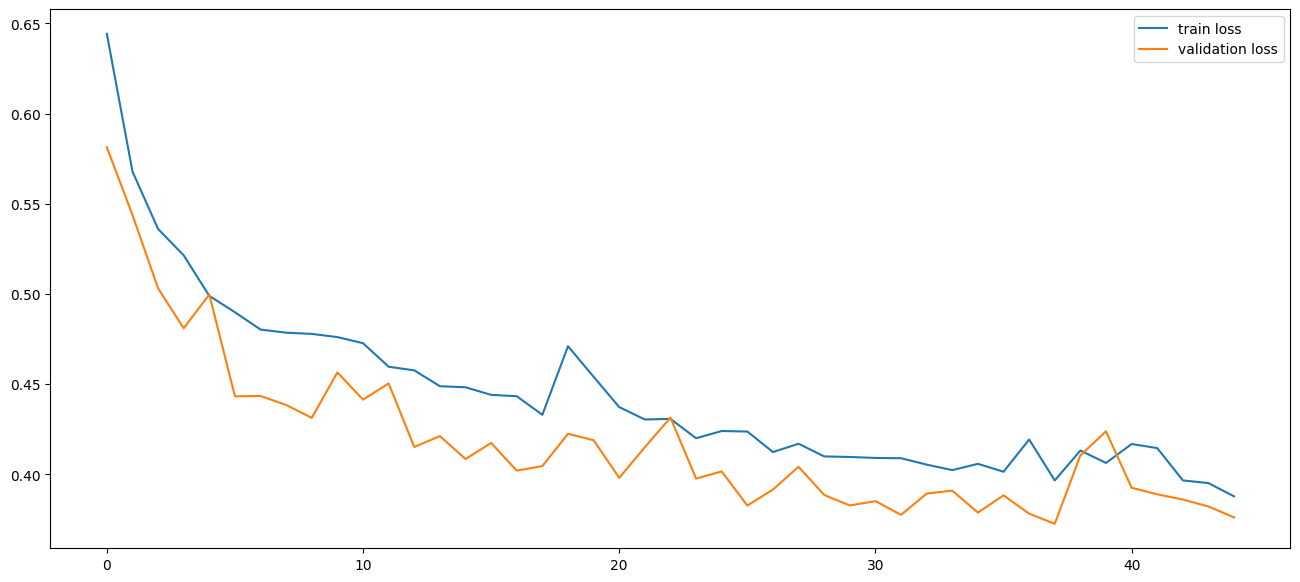

In [ ]:
plt.figure(figsize=(16,7))
plt.plot(history.history["loss"], label= "train loss")
plt.plot(history.history["val_loss"], label= "validation loss")
plt.legend()


16/16 [==============================] - 0s 22ms/step
Time for training LSTM (Tuned) is:  394 s
Time for testing LSTM (Tuned) is:  1 s
The accuracy score for  LSTM (Tuned) is:  0.826


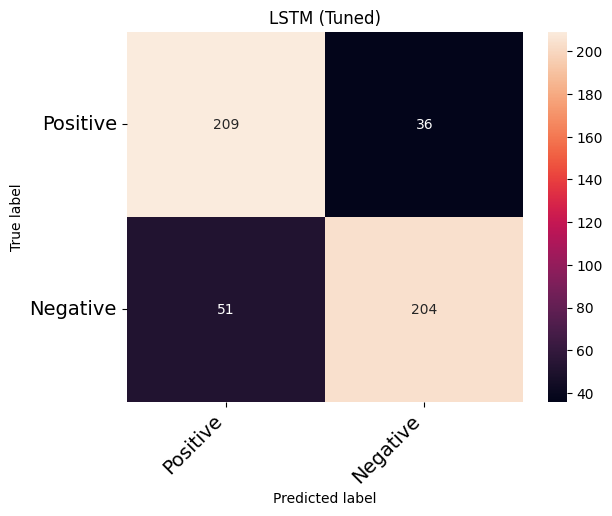

In [ ]:
start_predict = time.time()
ypred_LSTM_tuned = classifierLSTM.predict(X_val_small)
prediction_time = time.time() - start_predict
# Test and display results of tuned LSTM
displayResults(ypred_LSTM_tuned,Y_val_small,training_time,prediction_time,'LSTM (Tuned)')  


In [ ]:
print(classification_report(Y_val_small, ypred_LSTM_tuned))

              precision    recall  f1-score   support

           0       0.80      0.85      0.83       245
           1       0.85      0.80      0.82       255

    accuracy                           0.83       500
   macro avg       0.83      0.83      0.83       500
weighted avg       0.83      0.83      0.83       500



16/16 [==============================] - 0s 20ms/step
Time for training LSTM (Tuned) is:  394 s
Time for testing LSTM (Tuned) is:  1 s
The accuracy score for  LSTM (Tuned) is:  0.808


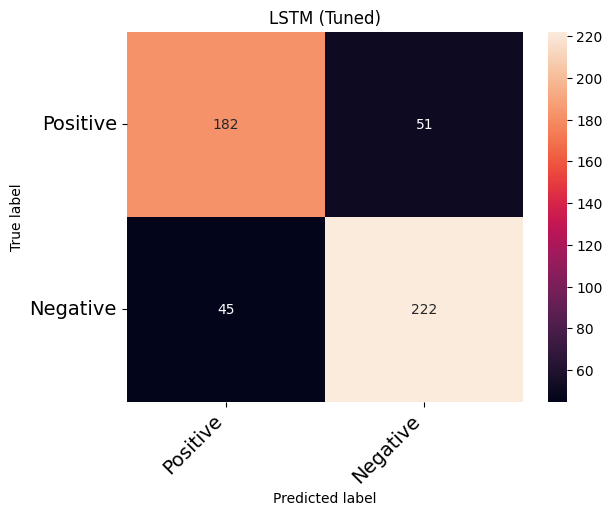

In [ ]:
#Tuning using subset of data
start_predict = time.time()
ypred_LSTM_tuned = classifierLSTM.predict(X_test_small)
prediction_time = time.time() - start_predict
# Test and display results of tuned LSTM using subset of data
displayResults(ypred_LSTM_tuned,Y_test_small,training_time,prediction_time,'LSTM (Tuned)')  

## Model Training using all the training data

In [ ]:
# Final LSTM Model Definition
optimizer = Adam(learning_rate=0.001)
initializera = tf.keras.initializers.GlorotUniform(seed=42)
finalLSTM = Sequential() # set up sequential model 
finalLSTM.add(LSTM(units = 8, input_shape=(max_length,vlength), kernel_initializer=initializera,recurrent_initializer=initializera,bias_initializer=initializers.Constant(0), kernel_regularizer=l2(0.00001), return_sequences = True)) #initialize simple RNN 
finalLSTM.add(Dropout(0.5))  
finalLSTM.add(LSTM(units = 32, kernel_initializer=initializera,recurrent_initializer=initializera,bias_initializer=initializers.Constant(0), kernel_regularizer=l2(0.00001)))#
finalLSTM.add(Dropout(0.2))
finalLSTM.add(Dense(units=10, activation='linear', kernel_initializer=initializera)) #Set the Dense layer with 10 units
finalLSTM.add(Dense(1, activation='sigmoid', kernel_initializer=initializera)) #output layer
finalLSTM.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy']) #loss function  
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)



In [ ]:
start_train = time.time()
history = finalLSTM.fit(X_train_new,Y_train,epochs=50,batch_size=32,verbose=2,validation_data=(X_val_new, Y_val), callbacks=[early_stop])
training_time = time.time() - start_train

Epoch 1/50
782/782 - 71s - loss: 0.5561 - accuracy: 0.7126 - val_loss: 0.5077 - val_accuracy: 0.7550 - 71s/epoch - 91ms/step
Epoch 2/50
782/782 - 62s - loss: 0.4924 - accuracy: 0.7684 - val_loss: 0.4663 - val_accuracy: 0.7802 - 62s/epoch - 79ms/step
Epoch 3/50
782/782 - 62s - loss: 0.4599 - accuracy: 0.7887 - val_loss: 0.4300 - val_accuracy: 0.8023 - 62s/epoch - 79ms/step
Epoch 4/50
782/782 - 62s - loss: 0.4304 - accuracy: 0.8085 - val_loss: 0.4103 - val_accuracy: 0.8116 - 62s/epoch - 79ms/step
Epoch 5/50
782/782 - 62s - loss: 0.4150 - accuracy: 0.8158 - val_loss: 0.4067 - val_accuracy: 0.8168 - 62s/epoch - 79ms/step
Epoch 6/50
782/782 - 62s - loss: 0.4086 - accuracy: 0.8220 - val_loss: 0.3973 - val_accuracy: 0.8234 - 62s/epoch - 79ms/step
Epoch 7/50
782/782 - 62s - loss: 0.4043 - accuracy: 0.8229 - val_loss: 0.3964 - val_accuracy: 0.8228 - 62s/epoch - 79ms/step
Epoch 8/50
782/782 - 62s - loss: 0.3973 - accuracy: 0.8281 - val_loss: 0.3816 - val_accuracy: 0.8322 - 62s/epoch - 80ms/step


In [ ]:
plt.figure()
plt.plot(history.history["loss"], label= "Training loss")
plt.plot(history.history["val_loss"], label= "Validation loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Binary Crossentropy")
plt.title("Loss vs Epochs LSTM")

In [ ]:
plt.figure()
plt.plot(history.history["accuracy"], label= "Training Accuracy")
plt.plot(history.history["val_accuracy"], label= "Validation Accuracy")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Binary Crossentropy")
plt.title("Accuracy vs Epochs LSTM")

In [ ]:
start_predict = time.time()
ypred_finalLSTM = finalLSTM.predict(X_val_new)
ypred_finalLSTM=(ypred_finalLSTM>=0.5).astype(int) #convert to binary (>0.5 means positive)
LSTMprediction_time = time.time() - start_predict

# Display Validation set results of final LSTM
displayResults(ypred_finalLSTM,Y_val,training_time,LSTMprediction_time,'LSTM (Tuned)')  
print(classification_report(Y_val, ypred_finalLSTM))

Time for training LSTM (final tuned) is:  0 s
Time for testing LSTM (final tuned) is:  22 s
The accuracy score for  LSTM (final tuned) is:  0.85976


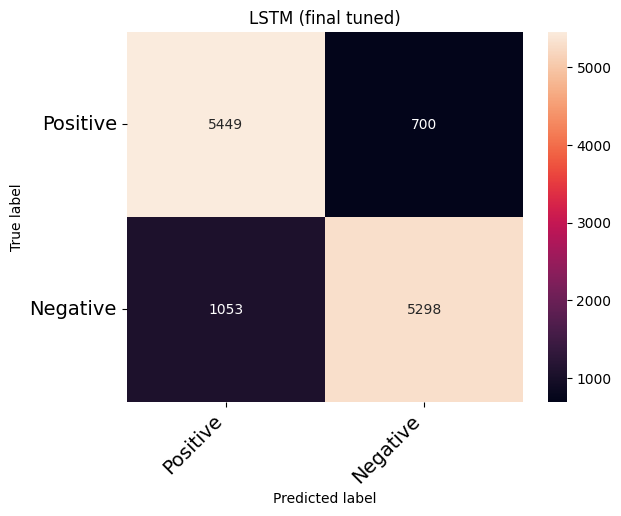

In [ ]:
start_predict = time.time()
ypred_finalLSTM = finalLSTM.predict(X_test_new)
ypred_finalLSTM=(ypred_finalLSTM>=0.5).astype(int) #convert to binary (>0.5 means positive)
LSTMprediction_time = time.time() - start_predict

# Display Test Set results of tuned LSTM
displayResults(ypred_finalLSTM,Y_test,training_time,LSTMprediction_time,'LSTM (final tuned)')  

In [ ]:
print(classification_report(Y_test, ypred_finalLSTM))

##Extracting Features with new model utilizing trained model weights

In [ ]:
from tensorflow.keras.models import load_model
finalLSTM = load_model('/content/drive/MyDrive/Machine Learning Project - ECE 9309/Data/myLSTMmodel1.h5')

In [ ]:
optimizer = Adam(learning_rate=0.001)
initializera = tf.keras.initializers.GlorotUniform(seed=42)
lstm_feature_extractor = keras.Sequential() # set up sequential model 
lstm_feature_extractor.add(LSTM(units = 8, input_shape=(max_length,vlength), kernel_initializer=initializera,recurrent_initializer=initializera,bias_initializer=initializers.Constant(0), kernel_regularizer=l2(0.00001), return_sequences = True)) #initialize simple RNN 
lstm_feature_extractor.add(LSTM(units = 32, kernel_initializer=initializera,recurrent_initializer=initializera,bias_initializer=initializers.Constant(0), kernel_regularizer=l2(0.00001)))
lstm_feature_extractor.add(Dense(units=10, activation='linear', kernel_initializer=initializera)) #Set the Dense layer with 10 units
    

lstm_weights0 = finalLSTM.layers[0].get_weights()
lstm_weights1 = finalLSTM.layers[2].get_weights()
lstm_weights2 = finalLSTM.layers[4].get_weights()

lstm_feature_extractor.layers[0].set_weights(lstm_weights0)
lstm_feature_extractor.layers[1].set_weights(lstm_weights1)
lstm_feature_extractor.layers[2].set_weights(lstm_weights2)
lstm_feature_extractor.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 1449, 8)           1888      
                                                                 
 lstm_11 (LSTM)              (None, 32)                5248      
                                                                 
Total params: 7,136
Trainable params: 7,136
Non-trainable params: 0
_________________________________________________________________


In [ ]:
finalLSTM.save('/content/drive/MyDrive/Machine Learning Project - ECE 9309/Data/finalLSTMmodel.h5')
#finalLSTM.layers[2].save_weights('/content/drive/MyDrive/Machine Learning Project - ECE 9309/Data/lstmweights1.h5')
#finalLSTM.layers[4].save_weights('/content/drive/MyDrive/Machine Learning Project - ECE 9309/Data/lstmweights2.h5')

In [ ]:
#Generate features
start=time.time()
Ftrain=lstm_feature_extractor.predict(X_train_new) 
Ftest=lstm_feature_extractor.predict(X_test_new)
end=time.time()

print('Time to extract features is: '"%.2f" % ((end-start)),'s')

391/391 [==============================] - 13s 32ms/step
Time to extract features is: 49.61 s


## Using XGBoost

Time for training XGBoost (default) is:  1 s
Time for testing XGBoost (default) is:  0 s
The accuracy score for  XGBoost (default) is:  0.86344


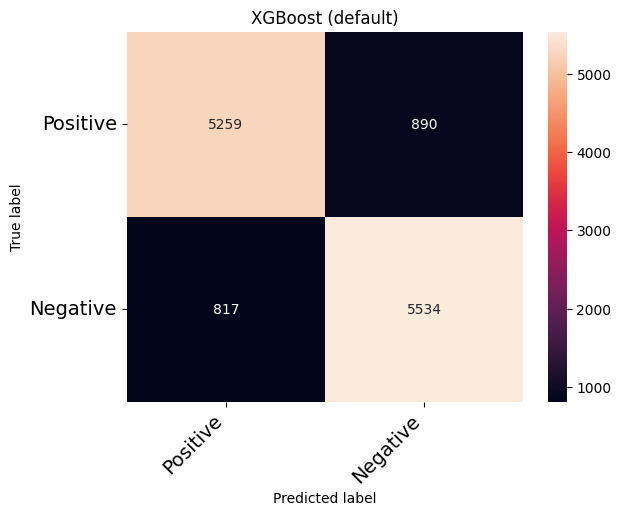

In [ ]:
#Untuned XGBoost
xgb_untuned = xgb.XGBClassifier(seed=42)
start = time.time()
xgb_untuned.fit(Ftrain, Y_train)
XGB_default_traintime = time.time() - start

start = time.time()
xgb_untuned_pred = xgb_untuned.predict(Ftest)
XGB_default_predictime = time.time() - start

displayResults(xgb_untuned_pred,Y_test,XGB_default_traintime,XGB_default_predictime,'XGBoost (default)')

##XGBoost Tuning

In [ ]:
xgb_tuned = xgb.XGBClassifier(seed=42)

XGBparams={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
 "max_depth"        : [7, 8, 9, 10, 12, 14, 16], #1, 3, 4, 5, 6,
 #"n_estimators"     : [int(x) for x in np.linspace(start=100, stop=2000, num=10)],
 #"min_child_weight" : [int(x) for x in np.arange(3, 15, 1)],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
 "subsample"        : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
 "colsample_bytree" : [0.5, 0.6, 0.7, 0.8, 0.9, 1],
 "colsample_bylevel": [0.5, 0.6, 0.7, 0.8, 0.9, 1],  
 
}

# Create an instance of RandomizedSearchCV with the hyperparameter grid and XGBoost classifier
XGB_search = RandomizedSearchCV(estimator=xgb_tuned, 
                                   param_distributions=XGBparams, 
                                   n_iter=30, 
                                   cv=3, 
                                   n_jobs=-1, 
                                   verbose =3,
                                   random_state = 42
                )

In [ ]:
# Fit RandomizedSearchCV on the training data and Calculate tuning time
start_time = time.time()
XGB_search.fit(Ftrain, Y_train_small)
XGBtuned_time = time.time() - start_time

# Get the best hyperparameters and model
best_params = XGB_search.best_params_
best_XGB = XGB_search.best_estimator_

Fitting 3 folds for each of 30 candidates, totalling 90 fits


{'subsample': 0.6, 'max_depth': 10, 'learning_rate': 0.05, 'gamma': 0.4, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.8}
Time for training XGBoost (Tuned) is:  3 s
Time for testing XGBoost (Tuned) is:  0 s
The accuracy score for  XGBoost (Tuned) is:  0.808


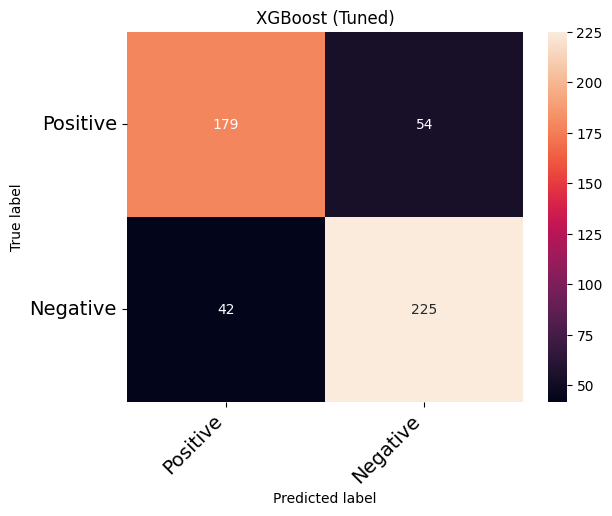

In [ ]:
#Tuning results using subset of data
start = time.time()
XGB_pred = best_XGB.predict(Ftest)
XGBtuned_predicttime = time.time() - start
print(best_params)
displayResults(XGB_pred,Y_test_small,XGB_default_traintime,XGBtuned_predicttime,'XGBoost (Tuned)')

[06:41:57] WARNING: ../src/learner.cc:767: 
Parameters: { "colample_bytree" } are not used.

Time for training XGBoost (tuned) is:  5 s
Time for testing XGBoost (tuned) is:  0 s
The accuracy score for  XGBoost (tuned) is:  0.86416


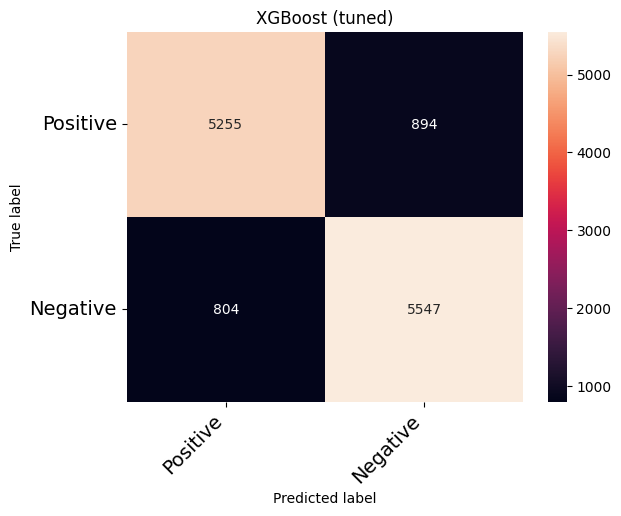

In [ ]:
xgb_tuned = xgb.XGBClassifier(subsample=1,n_estimators=311,min_child_weight=8,max_depth=3,learning_rate=0.05,gamma=0.4,colample_bytree=1,colsample_bylevel=0.5,seed=42)
start = time.time()
xgb_tuned.fit(Ftrain, Y_train)
XGB_default_traintime = time.time() - start

start = time.time()
xgb_tuned_pred = xgb_tuned.predict(Ftest)
XGB_default_predictime = time.time() - start

displayResults(xgb_tuned_pred,Y_test,XGB_default_traintime,XGB_default_predictime,'XGBoost (tuned)')

In [ ]:
print(classification_report(Y_test, xgb_tuned_pred))

              precision    recall  f1-score   support

           0       0.87      0.85      0.86      6149
           1       0.86      0.87      0.87      6351

    accuracy                           0.86     12500
   macro avg       0.86      0.86      0.86     12500
weighted avg       0.86      0.86      0.86     12500



## SVC (default)

Time for training SVC (default) is:  10 s
Time for testing SVC (default) is:  4 s
The accuracy score for  SVC (default) is:  0.86336


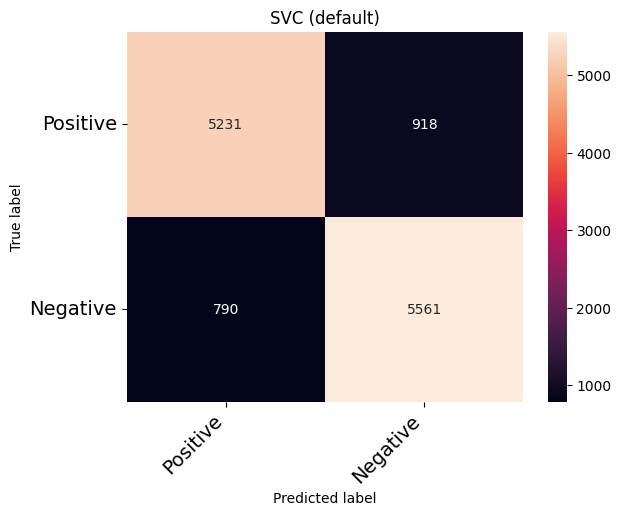

In [ ]:
from sklearn.svm import SVC
start=time.time()
fSVC = SVC(random_state = 42)
fSVCm = fSVC.fit(Ftrain, Y_train)
end=time.time()
timeoftrainSVCd=end-start

start=time.time()
ypredSVCd=fSVCm.predict(Ftest)
end=time.time()
timeoftestSVCd=end-start

displayResults(ypredSVCd,Y_test,timeoftrainSVCd,timeoftestSVCd,'SVC (default)')

## SVC (Tuning)

In [ ]:
search_space = {
    "C" : [0.01,0.1,1.0,10,100,1000],
    "kernel":['linear', 'poly', 'rbf', 'sigmoid'],
    "tol" : [1e-3, 1e-2, 1e-1, 1e0, 1e1,],
    #"max_iter" : [-1, 100, 1000, 10000],
    "random_state" : [42]
}

In [ ]:
svc = SVC()
SVCgs = GridSearchCV(estimator = svc,
                  param_grid=search_space,
                  cv = 5)

In [ ]:
start=time.time()
SVCt = SVCgs.fit(Ftrain,Y_train_small)
end=time.time()
timeoftrainSVCt=end-start

In [ ]:
print(SVCt.best_estimator_)
best_SVC = SVCt.best_estimator_

SVC(C=1000, random_state=42, tol=0.1)


Time for training SVC (tuned) is:  389 s
Time for testing SVC (tuned) is:  0 s
The accuracy score for  SVC (tuned) is:  0.798


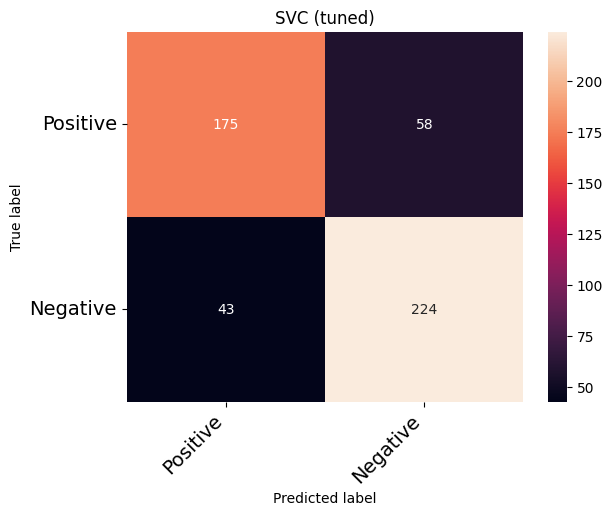

In [ ]:
#Tuning results using subset of data
start=time.time()
ypredSVCt= SVCt.best_estimator_.predict(Ftest)
end=time.time()
timeoftestSVCt=end-start
displayResults(ypredSVCt,Y_test_small,timeoftrainSVCt,timeoftestSVCt,'SVC (tuned)')

Time for training SVC (tuned) is:  11 s
Time for testing SVC (tuned) is:  3 s
The accuracy score for  SVC (tuned) is:  0.86328


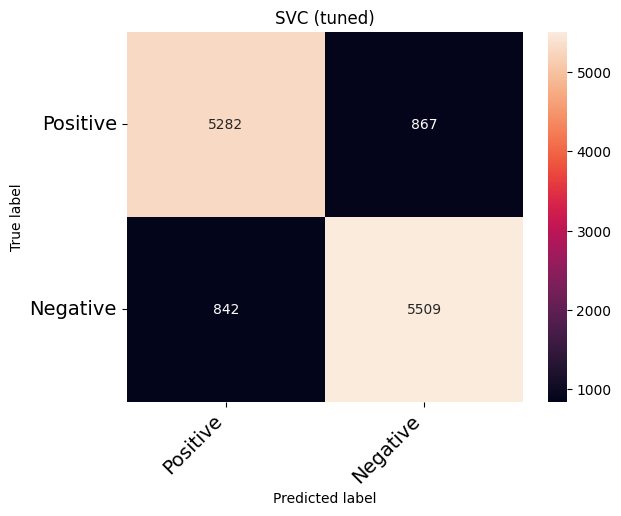

              precision    recall  f1-score   support

           0       0.86      0.86      0.86      6149
           1       0.86      0.87      0.87      6351

    accuracy                           0.86     12500
   macro avg       0.86      0.86      0.86     12500
weighted avg       0.86      0.86      0.86     12500



In [ ]:
start=time.time()
fSVC = SVC(C=0.001,kernel='linear',random_state = 42)
fSVCm = fSVC.fit(Ftrain,Y_train)
end=time.time()
timeoftrainSVCt=end-start

start=time.time()
ypredSVCt=fSVCm.predict(Ftest)
end=time.time()
timeoftestSVCt=end-start

displayResults(ypredSVCt,Y_test,timeoftrainSVCt,timeoftestSVCt,'SVC (tuned)')
print(classification_report(Y_test, ypredSVCt))

## KNN (default)

Time for training KNN (default) is:  0 s
Time for testing KNN (default) is:  1 s
The accuracy score for  KNN (default) is:  0.85744


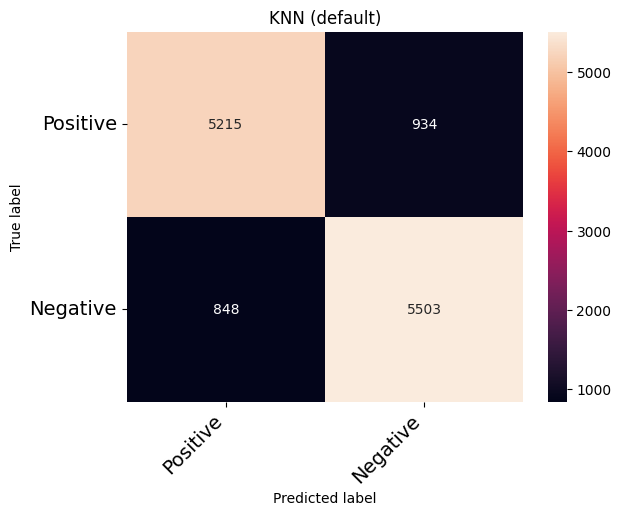

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
start=time.time()
fKNN = KNeighborsClassifier()
fKNNm = fKNN.fit(Ftrain,Y_train)
end=time.time()
timeoftrainKNNd=end-start

start=time.time()
ypredKNNd=fKNNm.predict(Ftest)
end=time.time()
timeoftestKNNd=end-start

displayResults(ypredKNNd,Y_test,timeoftrainKNNd,timeoftestKNNd,'KNN (default)')

## KNN (Tuning)

In [ ]:
search_space = {
    "n_neighbors" : [1, 2, 5, 10, 15, 20],
    "weights":['uniform', 'distance'],
}

In [ ]:
knn = KNeighborsClassifier()
KNNgs = GridSearchCV(estimator = knn,
                  param_grid=search_space,
                  cv = 5)

In [ ]:
start=time.time()
KNNt = KNNgs.fit(Ftrain,Y_train_small)
end=time.time()
timeoftrainKNNt=end-start

In [ ]:
print(KNNt.best_estimator_)
best_KNN = KNNt.best_estimator_

KNeighborsClassifier(n_neighbors=20)


Time for training KNN (tuned) is:  2 s
Time for testing KNN (tuned) is:  0 s
The accuracy score for  KNN (tuned) is:  0.798


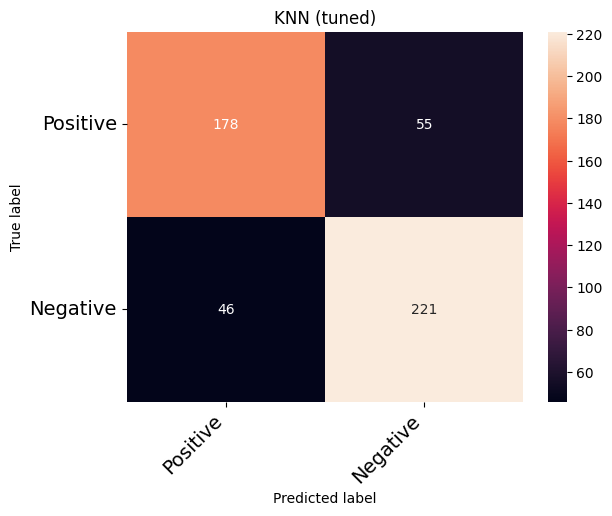

In [ ]:
# Tuning results using subset of data
start=time.time()
ypredKNNt= KNNt.best_estimator_.predict(Ftest)
end=time.time()
timeoftestKNNt=end-start
displayResults(ypredKNNt,Y_test_small,timeoftrainKNNt,timeoftestKNNt,'KNN (tuned)')

Time for training KNN (tuned) is:  0 s
Time for testing KNN (tuned) is:  2 s
The accuracy score for  KNN (tuned) is:  0.85904


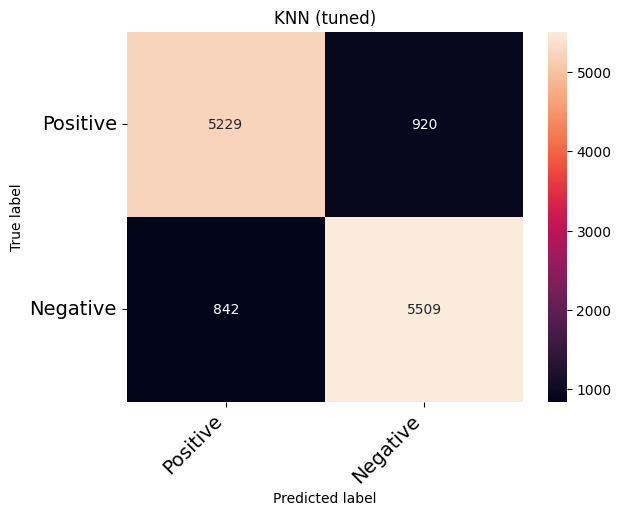

              precision    recall  f1-score   support

           0       0.86      0.85      0.86      6149
           1       0.86      0.87      0.86      6351

    accuracy                           0.86     12500
   macro avg       0.86      0.86      0.86     12500
weighted avg       0.86      0.86      0.86     12500



In [ ]:
start=time.time()
fKNN = KNeighborsClassifier(n_neighbors=15)
fKNNm = fKNN.fit(Ftrain,Y_train)
end=time.time()
timeoftrainKNNt=end-start

start=time.time()
ypredKNNt=fKNNm.predict(Ftest)
end=time.time()
timeoftestKNNt=end-start

displayResults(ypredKNNt,Y_test,timeoftrainKNNt,timeoftestKNNt,'KNN (tuned)')
print(classification_report(Y_test, ypredKNNt))

##Ensemble Learning

##Majority Vote

In [ ]:
sum3=(ypredSVCt+ypredKNNt+xgb_tuned_pred)>1.5 
ypredMR=sum3.astype(int)

Time for training Majority Rules is:  0 s
Time for testing Majority Rules is:  0 s
The accuracy score for  Majority Rules is:  0.86456


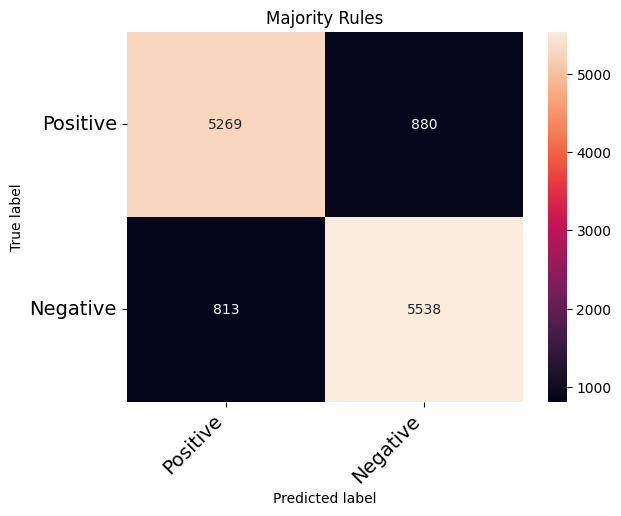

              precision    recall  f1-score   support

           0       0.87      0.86      0.86      6149
           1       0.86      0.87      0.87      6351

    accuracy                           0.86     12500
   macro avg       0.86      0.86      0.86     12500
weighted avg       0.86      0.86      0.86     12500



In [ ]:
displayResults(ypredMR,Y_test,0,0,'Majority Rules')
print(classification_report(Y_test, ypredMR))

##Weighted voting

In [ ]:
from sklearn.ensemble import VotingClassifier
# Define the ensemble model with the three base models and their default weights
ensemble_model = VotingClassifier(estimators=[('knn', best_KNN), ('svc', best_SVC), ('xgb', best_XGB)], voting='soft', weights=[0.4, 0.3, 0.3])

# Define the grid of weights to search over
param_grid = {'weights': [[w1, w2, w3] for w1 in np.arange(0.1, 1.0, 0.1) 
                          for w2 in np.arange(0.1, 1.0 - w1, 0.1) 
                          for w3 in [1.0-w1-w2 +1e-10]]}

# Perform a grid search over the weights
grid_search = GridSearchCV(ensemble_model, param_grid=param_grid, scoring='accuracy', cv=5)
start = time.time()
grid_search.fit(Ftrain, Y_train_small)
ensemble_traintime = time.time() - start

# Print the best weights and the corresponding validation score
print("Best weights:", grid_search.best_params_['weights'])
print("Validation score:", grid_search.best_score_)



In [ ]:
from sklearn.ensemble import VotingClassifier
# Define the ensemble model with the three base models and their default weights
ensemble_model = VotingClassifier(estimators=[('knn', KNNt.best_estimator_), ('svc', SVCt.best_estimator_), ('xgb', XGB_search.best_estimator_)], voting='soft', weights=[0.4, 0.3, 0.3])

# Define the grid of weights to search over
param_grid = {'weights': [[w1, w2, w3] for w1 in np.arange(0.1, 1.0, 0.1) 
                          for w2 in np.arange(0.1, 1.0-w1, 0.1) 
                          for w3 in [1.0-w1-w2]]}

# Perform a grid search over the weights
grid_search = GridSearchCV(ensemble_model, param_grid=param_grid, scoring='accuracy', cv=5)
start = time.time()
grid_search.fit(Ftrain, Y_train_small)
ensemble_traintime = time.time() - start

# Print the best weights and the corresponding validation score
print("Best weights:", grid_search.best_params_['weights'])
print("Validation score:", grid_search.best_score_)


In [ ]:
# Evaluate the performance of the best model on the test set
best_ensemble_model = grid_search.best_estimator_
start = time.time()
y_pred = best_ensemble_model.predict(X_test)
ensemble_predicttime = time.time() - start
test_score = accuracy_score(Y_test_small, y_pred)
print("Test score:", test_score)

displayResults(y_pred,Y_test_small,ensemble_traintime,ensemble_predicttime,'Ensemble (With Tuned weights)')